In [2]:
import os, sys
import numpy as np
sys.path.insert(0, '/Users/kit/Documents/code/fair-classification/disparate_mistreatment/synthetic_data_demo')
sys.path.insert(0, '/Users/kit/Documents/code/fair-classification/fair_classification/')
from generate_synthetic_data import *
import utils as ut
import funcs_disp_mist as fdm
import plot_syn_boundaries as psb

In [142]:
 def test_synthetic_data():
	
	""" Generate the synthetic data """
	data_type = 1
	X, y, x_control = generate_synthetic_data(data_type=data_type, plot_data=False) # set plot_data to False to skip the data plot
	sensitive_attrs = list(x_control.keys())

	""" Split the data into train and test """
	train_fold_size = 0.5
	x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

	cons_params = None # constraint parameters, will use them later
	loss_function = "logreg" # perform the experiments with logistic regression
	EPS = 1e-4

	def train_test_classifier():
		w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

		train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

		
		# accuracy and FPR are for the test because we need of for plotting
		return w, test_score, s_attr_to_fp_fn_test
		

	""" Classify the data while optimizing for accuracy """
	print()
	print("== Unconstrained (original) classifier ==")
	w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()
	print("\n-----------------------------------------------------------------------------------\n")

	""" Now classify such that we optimize for accuracy while achieving perfect fairness """
	
	print()
	print( "== Classifier with fairness constraint ==")


	print( "\n\n=== Constraints on FPR ===")	# setting parameter for constraints
	cons_type = 1 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
	tau = 5.0
	mu = 1.2
	sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:1e-6}, 1:{0:0, 1:1e-6}, 2:{0:0, 1:1e-6}}} # zero covariance threshold, means try to get the fairest solution
	cons_params = {"cons_type": cons_type, 
					"tau": tau, 
					"mu": mu, 
					"sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")

	print( "\n\n=== Constraints on FNR ===")
	cons_type = 2
	cons_params["cons_type"] = cons_type # FNR constraint -- just change the cons_type, the rest of parameters should stay the same
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")



	print( "\n\n=== Constraints on both FPR and FNR ===")
	cons_type = 4
	cons_params["cons_type"] = cons_type # both FPR and FNR constraints
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")


	return


== Unconstrained (original) classifier ==


Accuracy: 0.790
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.26 ||
||  1  || 0.10 || 0.15 ||



-----------------------------------------------------------------------------------


== Classifier with fairness constraint ==


=== Constraints on FPR ===


Accuracy: 0.757
||  s  || FPR. || FNR. ||
||  0  || 0.25 || 0.28 ||
||  1  || 0.30 || 0.14 ||




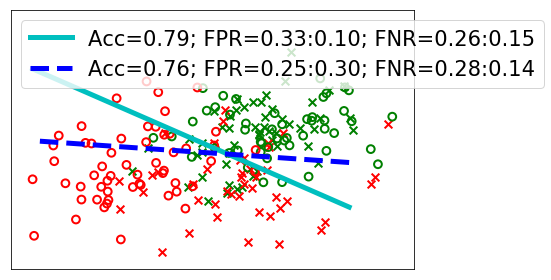


-----------------------------------------------------------------------------------



=== Constraints on FNR ===


Accuracy: 0.766
||  s  || FPR. || FNR. ||
||  0  || 0.60 || 0.16 ||
||  1  || 0.05 || 0.14 ||




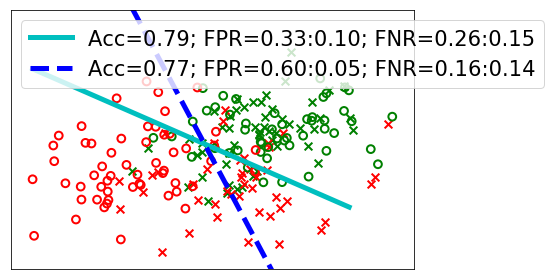


-----------------------------------------------------------------------------------



=== Constraints on both FPR and FNR ===


Accuracy: 0.600
||  s  || FPR. || FNR. ||
||  0  || 0.79 || 0.01 ||
||  1  || 0.80 || 0.00 ||




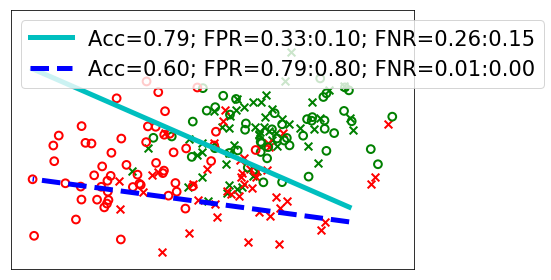


-----------------------------------------------------------------------------------



In [143]:
test_synthetic_data()

## JOCO DATA TEST

In [3]:
import pandas as pd

FILE_PATH = '/Volumes/dbs/triage-working/matrices'

label_col = 'booking_view_warr_bw_1y'
demo_col = 'race_nonwhite'
exclude_cols = ['entity_id', 'as_of_date', label_col, demo_col]

def load_matrix(matrix_id, non_white):
    df = pd.read_csv('%s/%s.csv' % (FILE_PATH, matrix_id))
    df[demo_col] = non_white
    df[label_col] = 2*(df[label_col] - 0.5)
    return df

# training data
df_b_train = load_matrix('bf8f725453aebbcf3decbb72fcf95e6e', 1)
df_h_train = load_matrix('ee4a84ff473f0af6acf7d35432dcddfa', 1)
df_w_train = load_matrix('f6baf93649b912647017bb15b87131e0', 0)

df_train = pd.concat([df_b_train, df_h_train, df_w_train], axis=0)

x_train = df_train[[c for c in df_train.columns if c not in exclude_cols]].values
y_train = df_train[label_col].values
x_control_train = {demo_col: df_train[demo_col].values}


# test data
df_b_test = load_matrix('b6e936186bec0885640f5a0bb8ab787b', 1)
df_h_test = load_matrix('6b616fa0db246fc6222049e709efd430', 1)
df_w_test = load_matrix('0db1a017699f3d3142d7688128f844f1', 0)

df_test = pd.concat([df_b_test, df_h_test, df_w_test], axis=0)

x_test = df_test[[c for c in df_test.columns if c not in exclude_cols]].values
y_test = df_test[label_col].values
x_control_test = {demo_col: df_test[demo_col].values}



In [5]:
x_train.shape

(26369, 3565)

In [6]:
df_train.shape

(26369, 3569)

In [8]:
# TODO for JOCO Data:
# 1. load a training and test set
# 2. add columns to feature matrices for constant term (assumed to be in the X matrix here)
# 3. scale matrices as in scaled logit
# 4. read in race_3way and modify to race_2way for x_control
# 5. run a lasso logit as a means of feature selection
# 6. set up parameters for disparate mistreatment logit (cons_type=2 for FNR <=> recall)
# 7. run regressions, test on test set
# 8. iterate over full set of matrices/as_of_dates


# MAYBE modify the package with...
# - ability to use a ridge or lasso loss function
# - allow for multiple sensitive features (e.g., one-hot enconded categorical?)


loss_function = "logreg"
EPS = 1e-4
cons_params = None

def train_test_classifier():
    w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

    train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

    # accuracy and FPR are for the test because we need of for plotting
    return w, test_score, s_attr_to_fp_fn_test


In [9]:
# Unconstrained classifier

cons_params = None

w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()

Traceback (most recent call last):
  File "/Users/kit/Documents/code/fair-classification/fair_classification/funcs_disp_mist.py", line 109, in train_model_disp_mist
    max_iters=max_iters, max_iter=max_iter_dccp)
  File "/Users/kit/.pyenv/versions/kit-joco-3.6.8/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/Users/kit/.pyenv/versions/kit-joco-3.6.8/lib/python3.6/site-packages/dccp/problem.py", line 42, in dccp
    result_temp = iter_dccp(self, max_iter, tau, mu, tau_max, solver, ep, max_slack, **kwargs)
  File "/Users/kit/.pyenv/versions/kit-joco-3.6.8/lib/python3.6/site-packages/dccp/problem.py", line 227, in iter_dccp
    logger.info("iteration=%d, cost value=%.5f, tau=%.5f", it, prob_new.solve(solver=solver, **kwargs), tau)
  File "/Users/kit/.pyenv/versions/kit-joco-3.6.8/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/U

SystemExit: 1

/Users/kit/.pyenv/versions/kit-joco-3.6.8/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# FNR fairness-constrained classifier

cons_type = 2 # FNR constraint -- same as recall
tau = 5.0
mu = 1.2
# note thresh for constraints will be cov_thresh[1] - cov_thresh[0]
# had trouble satisfying exact 0s here in synthetic data tests, so go with small epsilon, 1e-6...
sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:1e-6}, 1:{0:0, 1:1e-6}, 2:{0:0, 1:1e-6}}} # zero covariance threshold, means try to get the fairest solution
cons_params = {"cons_type": cons_type, 
                "tau": tau, 
                "mu": mu, 
                "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

w_cons, acc_cons, s_attr_to_fp_fn_test_cons = train_test_classifier()

In [12]:
x = x_train
y = y_train
x_control = x_control_train

max_iters = 150
max_iter_dccp = 75

num_points, num_features = x.shape

import cvxpy

w = cvxpy.Variable(num_features)

np.random.seed(112233)

w.value = np.random.rand(x.shape[1])

constraints = []
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)

tau, mu = 0.005, 1.2

In [13]:
prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=True, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.424e+04  +2e+05  6e-01  2e+02  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.550e-01  -1.898e+04  +1e+05  1e-01  1e+02  6e-01  6e-01  0.5013  2e-01   2  1  1 |  3  3
 2  +1.095e+00  -1.498e+04  +8e+04  1e-01  1e+02  4e-01  5e-01  0.5013  6e-01   1  1  2 |  8  3
 3  +1.182e+00  -1.380e+04  +8e+04  9e-02  1e+02  4e-01  4e-01  0.9791  9e-01   2  1  1 | 16  0
 4  +1.334e+00  -1.142e+04  +6e+04  7e-02  9e+01  3e-01  3e-01  0.5013  7e-01   2  1  1 |  9  3
 5  +1.387e+00  -1.075e+04  +6e+04  7e-02  9e+01  3e-01  3e-01  0.9791  9e-01   2  1  1 | 17  0
 6  +1.566e+00  -8.193e+03  +5e+04  5e-02  7e+01  2e-01  3e-01  0.4010  4e-01   2  1  1 |  6  4
 7  +1.725e+00  -6.239e+03  +4e+04  3e-02  5e+01  2e-01  2e-01  0.4010  4e-01   2  2  1 |  6  4
 8  +1.873e+00  -4.748e+03  +3e+04  3e-02  4e+

84  +2.830e-01  +2.830e-01  +2e-04  4e-11  5e-06  5e-11  1e-09  0.9791  1e+00   1  0  1 | 20  0
85  +2.830e-01  +2.830e-01  +2e-04  4e-11  5e-06  4e-11  1e-09  0.4010  8e-01   2  1  0 | 12  4
86  +2.830e-01  +2.830e-01  +2e-04  4e-11  5e-06  4e-11  1e-09  0.9791  1e+00   1  1  1 | 20  0
87  +2.830e-01  +2.830e-01  +2e-04  3e-11  4e-06  4e-11  1e-09  0.5013  8e-01   2  0  1 | 13  3
88  +2.830e-01  +2.830e-01  +2e-04  3e-11  4e-06  4e-11  1e-09  0.9791  1e+00   1  0  1 | 24  0
89  +2.830e-01  +2.830e-01  +2e-04  3e-11  4e-06  4e-11  9e-10  0.4010  8e-01   1  0  1 | 12  4
90  +2.830e-01  +2.830e-01  +2e-04  3e-11  4e-06  3e-11  9e-10  0.9791  1e+00   1  0  0 | 19  0
91  +2.830e-01  +2.830e-01  +1e-04  3e-11  4e-06  3e-11  8e-10  0.7833  9e-01   2  1  1 | 16  1
92  +2.830e-01  +2.830e-01  +1e-04  3e-11  4e-06  3e-11  8e-10  0.9791  1e+00   2  1  1 | 22  0
93  +2.830e-01  +2.830e-01  +1e-04  3e-11  3e-06  3e-11  7e-10  0.4010  8e-01   2  1  0 | 12  4
94  +2.830e-01  +2.830e-01  +1e-04  3e-1

66  +2.831e-01  +2.830e-01  +6e-04  1e-10  2e-05  1e-10  4e-09  0.4010  7e-01   2  1  1 |  9  4
67  +2.831e-01  +2.830e-01  +6e-04  1e-10  2e-05  1e-10  3e-09  0.9791  1e+00   1  1  0 | 25  0
68  +2.831e-01  +2.830e-01  +6e-04  1e-10  1e-05  1e-10  3e-09  0.4010  8e-01   2  1  0 | 12  4
69  +2.831e-01  +2.830e-01  +6e-04  1e-10  1e-05  1e-10  3e-09  0.9791  1e+00   2  1  0 | 25  0
70  +2.830e-01  +2.830e-01  +5e-04  1e-10  1e-05  1e-10  3e-09  0.4010  8e-01   1  0  1 | 11  4
71  +2.830e-01  +2.830e-01  +5e-04  1e-10  1e-05  1e-10  3e-09  0.9791  9e-01   2  0  0 | 18  0
72  +2.830e-01  +2.830e-01  +5e-04  9e-11  1e-05  1e-10  3e-09  0.5013  8e-01   1  1  0 | 13  3
73  +2.830e-01  +2.830e-01  +4e-04  8e-11  1e-05  1e-10  2e-09  0.9791  1e+00   1  0  0 | 19  0
74  +2.830e-01  +2.830e-01  +4e-04  8e-11  1e-05  9e-11  2e-09  0.4010  8e-01   1  0  1 | 11  4
75  +2.830e-01  +2.830e-01  +4e-04  7e-11  9e-06  8e-11  2e-09  0.9791  9e-01   1  1  1 | 17  0
76  +2.830e-01  +2.830e-01  +3e-04  6e-1

(0.2830332312706512,
 [array([ -0.39223084,  -1.25630637,   0.10892492, ...,   0.3870304 ,
         -15.59901695,   3.0827189 ])])

In [15]:
ret_w = np.array(w.value).flatten()

In [24]:
x_control_train = {demo_col: x_control_train}
x_control_test = {demo_col: x_control_test}
sensitive_attrs = list(x_control_train.keys())

In [25]:
train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(ret_w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, list(sensitive_attrs))



Accuracy: 0.799
||  s  || FPR. || FNR. ||
||  0  || 0.10 || 0.80 ||
||  1  || 0.10 || 0.82 ||




In [26]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w, x_test, x_control_test[s_attr])

In [79]:

def label_top_k(distances, k):
    sort_df = pd.DataFrame({'dist': distances})
    sort_df.sort_values('dist', ascending=False, inplace=True)
    sort_df['pred_label'] = -1
    sort_df['orig_idx'] = sort_df.index
    sort_df.reset_index(inplace=True)
    i = k-1
    sort_df.loc[:i,'pred_label'] = 1
    sort_df.sort_values('orig_idx', inplace=True)
    return sort_df['pred_label'].values

def calc_prec(pred_label, actual_label):
    label_pos = sum((pred_label == 1).astype(int))
    true_pos = sum(np.logical_and(pred_label == actual_label, pred_label == 1).astype(int))
    return float(true_pos/label_pos)

k = 100

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))


prec@100_abs: 0.35000
recall non-white: 0.004670
recall white: 0.012733
recall ratio: 2.726694


In [80]:
# 35% precision is incredibly low here -- likely because the logistic loss is totally unregularized,
# so presumably we're getting a massively overfit model...

# let's take a look at training set precision as an indication

k = 100
distances_boundary_train = fdm.get_distance_boundary(ret_w, x_train, x_control_train[s_attr])

all_class_labels_assigned_train = label_top_k(distances_boundary_train, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_train, y_train)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_train = fdm.get_fpr_fnr_sensitive_features(y_train, all_class_labels_assigned_train, x_control_train, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_train.keys():
    for s_val in s_attr_to_fp_fn_train[s_attr].keys():
        s_attr_to_fp_fn_train[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_train[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_train['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_train['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))

prec@100_abs: 1.00000
recall non-white: 0.015428
recall white: 0.036568
recall ratio: 2.370285


yup -- training set precision at 100 is 100%, compared to 35% on the test set, so we're massively overfit.

Unfortunately, the best bet here is probably to scale the data and use a lasso to do feature selection, though perhaps we could simply pull the existing feature importances from the triage database as a first step here (scaling isn't strictly necessary since there's no regularization term here)

In [91]:
# load columns with non-zero lasso coefficients from one of the old models

from sklearn.externals import joblib

old_mod_hash = '/Users/kit/Documents/joco_working/5270794c51b1de17745de599be68e951'
old_mat_hash = '/Users/kit/Documents/joco_working/510a0fbff9a6f649ef881fe07b12b08e'
old_mod = joblib.load(open(old_mod_hash, 'rb'))
old_mat = pd.read_csv('%s.csv' % old_mat_hash, nrows=1)
old_exclude_cols = ['entity_id', 'as_of_date', 'booking_view_warr_bw_1y']

all_cols = [c for c in old_mat.columns if c not in old_exclude_cols]
keep_cols = []
for i, col in enumerate(all_cols):
    if old_mod.coef_[0][i] != 0:
        keep_cols.append(col)

keep_cols = keep_cols + ['intercept']

In [96]:
# forgot to do this above...
df_train['intercept'] = 1
df_test['intercept'] = 1

x_train = df_train[[c for c in df_train.columns if c in keep_cols]].values
y_train = df_train[label_col].values
x_control_train = {demo_col: df_train[demo_col].values}

x_test = df_test[[c for c in df_test.columns if c in keep_cols]].values
y_test = df_test[label_col].values
x_control_test = {demo_col: df_test[demo_col].values}

In [103]:
x = x_train
y = y_train
x_control = x_control_train

max_iters = 150
max_iter_dccp = 75

num_points, num_features = x.shape

import cvxpy

w = cvxpy.Variable(num_features)

np.random.seed(112233)

w.value = np.random.rand(x.shape[1])

constraints = []
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)

tau, mu = 0.005, 1.2


prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=True, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.430e+04  +2e+05  6e-01  1e+02  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.654e-01  -1.901e+04  +1e+05  3e-01  9e+01  6e-01  6e-01  0.5013  2e-01   1  1  1 |  3  3
 2  +1.106e+00  -1.516e+04  +9e+04  2e-01  7e+01  5e-01  5e-01  0.4010  5e-01   1  1  1 |  7  4
 3  +1.221e+00  -1.367e+04  +8e+04  2e-01  7e+01  4e-01  4e-01  0.9791  9e-01   1  1  1 | 15  0
 4  +1.379e+00  -1.133e+04  +6e+04  1e-01  6e+01  3e-01  3e-01  0.5013  7e-01   1  1  1 |  9  3
 5  +1.391e+00  -1.128e+04  +6e+04  1e-01  5e+01  3e-01  3e-01  0.9791  1e+00   1  1  1 | 25  0
 6  +1.582e+00  -8.595e+03  +5e+04  1e-01  4e+01  3e-01  3e-01  0.4010  4e-01   1  1  1 |  6  4
 7  +1.749e+00  -6.546e+03  +4e+04  8e-02  3e+01  2e-01  2e-01  0.4010  4e-01   2  1  1 |  6  4
 8  +1.962e+00  -4.277e+03  +3e+04  5e-02  2e+

(0.3206479723796644,
 [array([-6.23709809e-01, -7.83707663e-02,  9.02976180e-02,  4.40202206e-01,
         -2.80270295e-02,  1.59193032e-01,  1.73208014e-01,  4.07055292e-03,
          1.87704231e-01, -6.71987209e-02, -1.22358449e-03,  3.51759277e-02,
         -3.53644523e-02, -2.13920281e-01,  7.66965734e-02,  1.19685021e-01,
         -2.11355401e-01,  1.05700225e-02,  1.11622233e-01,  8.47816778e-02,
         -7.91770220e-03,  4.64958048e-02,  4.26145754e-01,  8.78776207e-02,
          1.90660092e-01, -6.89096449e-02,  1.37000542e-01, -6.94801586e-04,
         -8.76853376e-04, -1.39379380e-03, -1.81324537e-02,  2.97822806e-02,
         -1.56392988e-02, -5.99718760e-01,  1.13236785e-01,  4.75484508e-02,
         -7.88765051e-02,  3.29603210e-02,  1.82712252e-01,  3.39362458e-02,
          2.99770642e-01, -7.10141856e-02, -7.10141488e-02, -7.10141488e-02,
          3.68064823e-01, -5.58683158e-01, -1.90451821e+00,  1.18244981e-01,
         -1.61036360e-01, -1.61036357e-01, -1.61036357e

In [130]:
ret_w_uncons = np.array(w.value).flatten()

train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(ret_w_uncons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, list(sensitive_attrs))



Accuracy: 0.855
||  s  || FPR. || FNR. ||
||  0  || 0.04 || 0.80 ||
||  1  || 0.03 || 0.85 ||




In [105]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w_uncons, x_test, x_control_test[s_attr])

k = 100

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))


prec@100_abs: 0.51000
recall non-white: 0.010674
recall white: 0.015916
recall ratio: 1.491161


In [131]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w_uncons, x_test, x_control_test[s_attr])

k = 500

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))


prec@500_abs: 0.52600
recall non-white: 0.048032
recall white: 0.086858
recall ratio: 1.808328


Ok -- that's at least a bit more in line with what we've seen with the regularized logistic regressions in general, so at least this makes a little more sense.

In [107]:
# let's take a look at training set precision as an indication

k = 100
distances_boundary_train = fdm.get_distance_boundary(ret_w_uncons, x_train, x_control_train[s_attr])

all_class_labels_assigned_train = label_top_k(distances_boundary_train, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_train, y_train)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_train = fdm.get_fpr_fnr_sensitive_features(y_train, all_class_labels_assigned_train, x_control_train, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_train.keys():
    for s_val in s_attr_to_fp_fn_train[s_attr].keys():
        s_attr_to_fp_fn_train[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_train[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_train['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_train['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))

prec@100_abs: 0.97000
recall non-white: 0.018233
recall white: 0.033286
recall ratio: 1.825634


Admittedly, still seems a bit overfit and we could consider stronger regularization for the feature selection, but given the test set error in line with other models, I think we can forge ahead with this for now and see how it performs including the FNR fairness constraints.

In [109]:
loss_function = "logreg"
EPS = 1e-4
cons_params = None

def train_test_classifier():
    w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

    train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

    # accuracy and FPR are for the test because we need of for plotting
    return w, test_score, s_attr_to_fp_fn_test


# FNR fairness-constrained classifier

cons_type = 2 # FNR constraint -- same as recall
tau = 5.0
mu = 1.2
# note thresh for constraints will be cov_thresh[1] - cov_thresh[0]
# had trouble satisfying exact 0s here in synthetic data tests, so go with small epsilon, 1e-6...
sensitive_attrs_to_cov_thresh = {"race_nonwhite": {0:{0:0, 1:1e-6}, 1:{0:0, 1:1e-6}, 2:{0:0, 1:1e-6}}} # zero covariance threshold, means try to get the fairest solution
cons_params = {"cons_type": cons_type, 
                "tau": tau, 
                "mu": mu, 
                "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

ret_w, acc_cons, s_attr_to_fp_fn_test_cons = train_test_classifier()



Accuracy: 0.855
||  s  || FPR. || FNR. ||
||  0  || 0.04 || 0.81 ||
||  1  || 0.03 || 0.84 ||




A little surprising that this doesn't yield perfectly-balanced FNR at the original decision boundary, or even particularly close, but let's see what happens at the top 100...

In [110]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w, x_test, x_control_test[s_attr])

k = 100

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))

prec@100_abs: 0.53000
recall non-white: 0.010674
recall white: 0.016826
recall ratio: 1.576370


Not much change from the unconstrained model (in fact, a little worse) and the raw ratio is very high compared to what we get after choosing separate thresholds, while the precision is much lower that we can achieve with random forests.

In [116]:
s_attr = sensitive_attrs[0]
distances_boundary_test = fdm.get_distance_boundary(ret_w, x_test, x_control_test[s_attr])

k = 500

all_class_labels_assigned_test = label_top_k(distances_boundary_test, k)
#all_class_labels_assigned_test = np.sign(distances_boundary_test)

prec_k = calc_prec(all_class_labels_assigned_test, y_test)

print('prec@%s_abs: %.5f' % (k, prec_k))

s_attr_to_fp_fn_test = fdm.get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, False)

for s_attr in s_attr_to_fp_fn_test.keys():
    for s_val in s_attr_to_fp_fn_test[s_attr].keys():
        s_attr_to_fp_fn_test[s_attr][s_val]['recall'] = 1.000-s_attr_to_fp_fn_test[s_attr][s_val]['fnr']


recall_nonwhite = s_attr_to_fp_fn_test['race_nonwhite'][1]['recall']
recall_white = s_attr_to_fp_fn_test['race_nonwhite'][0]['recall']

print('recall non-white: %.6f' % recall_nonwhite)
print('recall white: %.6f' % recall_white)
print('recall ratio: %.6f' % float(recall_white/recall_nonwhite))

prec@500_abs: 0.52400
recall non-white: 0.049366
recall white: 0.085493
recall ratio: 1.731819


Almost identical story at k=500 as well.

Overall, this approach doesn't seem to working particularly well in the "top k" setting, which isn't terribly surprising since it wasn't designed for that (it's attempting to balance FNR based on the decision boundary from the underlying optimization problem, so there's no good reason to believe that simply shifting this boundary to yield a smaller set would preserve the fairness constraints as well). It wouldn't be fair to entirely discount this method because it doesn't work here, but we certainly do need methods that can work with the top k/resource constrained setting, as well as the flexibility to apply to a broader array of modeling methods than simple linear models as employed here.

Given this, it doesn't strike me as particularly worthwhile to clean up the code here to get this working robustly across every joco as_of_date / other datasets. Rather, I think we could provide it as a simple case study at the outset and then focus more deeply on the strategies that are better suited to the top k problem.


In [133]:
# let's pickle a couple of things for potential future use / figure creation...

import pickle

export_dict = {
    'inputs': {
        'x_train': x_train,
        'x_control_train': x_control_train,
        'y_train': y_train,
        'x_test': x_test,
        'x_control_test': x_control_test,
        'y_test': y_test,
        'sensitive_attrs': sensitive_attrs
    },
    'unconstrained': {
        'model_output': {
            'w': ret_w_uncons
        },
        'top_100_abs': {
            'precision': 0.51000,
            'recall_non_white': 0.010674,
            'recall_white': 0.015916,
            'recall_ratio': 1.491161
        },
        'top_500_abs': {
            'precision': 0.52600,
            'recall_non_white': 0.048032,
            'recall_white': 0.086858,
            'recall_ratio': 1.808328
        }
    },
    'FNR constrined': {
        'model_output': {
            'w': ret_w
        },
        'top_100_abs': {
            'precision': 0.53000,
            'recall_non_white': 0.010674,
            'recall_white': 0.016826,
            'recall_ratio': 1.576370
        },
        'top_500_abs': {
            'precision': 0.52400,
            'recall_non_white': 0.049366,
            'recall_white': 0.085493,
            'recall_ratio': 1.731819
        }
    }
}

pickle.dump(export_dict, open('zafar_fair_classification.pkl', 'wb'))


In [134]:
del(export_dict)

## DEBUGGING....

In [94]:
data_type=1

In [95]:
X, y, x_control = generate_synthetic_data(data_type=data_type, plot_data=False)

In [97]:
train_fold_size = 0.5

In [98]:
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

In [99]:
cons_params = None

In [100]:
loss_function = "logreg"

In [101]:
EPS = 1e-4

In [102]:
	def train_test_classifier():
		w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

		train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

		
		# accuracy and FPR are for the test because we need of for plotting
		return w, test_score, s_attr_to_fp_fn_test

In [103]:
w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

In [104]:
x = x_train
y = y_train
x_control = x_control_train

max_iters = 100
max_iter_dccp = 50

num_points, num_features = x.shape

In [105]:
import cvxpy

In [106]:
w = cvxpy.Variable(num_features)

In [107]:
np.random.seed(112233)

In [108]:
w.value = np.random.rand(x.shape[1])

In [109]:
constraints = []

In [110]:
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points

In [111]:
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)

In [112]:
prob.is_dcp()

True

In [113]:
from dccp.problem import is_dccp
is_dccp(prob)

True

In [114]:
tau, mu = 0.005, 1.2

In [115]:
prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=False, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)

(0.43755525928491373, [array([-0.28275039,  0.34065621,  0.47560116])])

In [116]:
prob.status

In [117]:
ret_w = np.array(w.value).flatten()

In [118]:
train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(ret_w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, list(sensitive_attrs))



Accuracy: 0.813
||  s  || FPR. || FNR. ||
||  0  || 0.28 || 0.26 ||
||  1  || 0.11 || 0.12 ||




In [119]:
w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = ret_w, test_score, s_attr_to_fp_fn_test

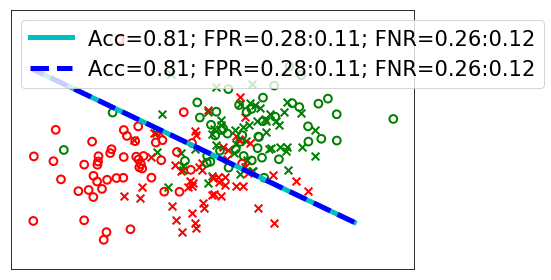

In [120]:
psb.plot_boundaries(X, y, x_control, [w_uncons, w_uncons], [acc_uncons, acc_uncons], 
                   [s_attr_to_fp_fn_test_uncons['s1'], s_attr_to_fp_fn_test_uncons['s1']],
                   "test_output.png")

In [121]:
print( "\n\n=== Constraints on FPR ===")	# setting parameter for constraints
cons_type = 2 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
tau = 5.0
mu = 1.2
sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:0.000001}, 1:{0:0, 1:0.000001}, 2:{0:0, 1:0.000001}}} # zero covariance threshold, means try to get the fairest solution
cons_params = {"cons_type": cons_type, 
                "tau": tau, 
                "mu": mu, 
                "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}



=== Constraints on FPR ===


In [122]:
w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()

TypeError: 'dict_keys' object does not support indexing

In [123]:
import cvxpy

x = x_train
y = y_train
x_control = x_control_train

max_iters = 100
max_iter_dccp = 50

num_points, num_features = x.shape

In [124]:
w = cvxpy.Variable(num_features) # this is the weight vector

np.random.seed(112233)
w.value = np.random.rand(x.shape[1])

constraints = fdm.get_constraint_list_cov(x, y, x_control, cons_params["sensitive_attrs_to_cov_thresh"], cons_params["cons_type"], w)

In [125]:
constraints

[Inequality(Expression(CONCAVE, NONPOSITIVE, ())),
 Inequality(Expression(CONCAVE, NONPOSITIVE, ()))]

In [126]:
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points

In [127]:
cons_params.get('take_initial_sol')

In [128]:
take_initial_sol = True

In [129]:
w.value

array([0.58377473, 0.76386   , 0.26510156])

In [130]:
p = cvxpy.Problem(cvxpy.Minimize(loss), [])
p.solve()

0.43755525982423127

In [131]:
w.value

array([-0.28274915,  0.34065479,  0.47559923])

In [133]:
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)
# prob = cvxpy.Problem(cvxpy.Minimize(loss), [cvxpy.norm(w) >= 0.1])

In [134]:
cons_params.get('tau')

5.0

In [135]:
cons_params.get('mu')

1.2

In [136]:
tau = cons_params.get('tau')
mu = cons_params.get('mu')

In [137]:
prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=True, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.070e+03  +2e+04  6e-01  1e+01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.927e+01  -1.236e+03  +7e+03  2e-01  6e+00  4e-01  4e-01  0.7833  2e-01   1  0  0 |  0  1
 2  +1.548e+01  -4.474e+02  +3e+03  7e-02  3e+00  2e-01  2e-01  0.6266  8e-02   1  0  0 |  0  2
 3  +1.066e+01  -1.410e+02  +1e+03  2e-02  2e+00  7e-02  7e-02  0.6266  8e-02   0  0  0 |  0  2
 4  +6.305e+00  -2.376e+01  +3e+02  3e-03  7e-01  2e-02  2e-02  0.7778  2e-02   0  0  0 |  0  1
 5  +4.678e+00  -7.441e+00  +1e+02  1e-03  3e-01  6e-03  7e-03  0.6266  1e-01   0  0  0 |  2  2
 6  +3.175e+00  -1.273e+00  +5e+01  5e-04  9e-02  2e-03  3e-03  0.6187  7e-02   0  0  0 |  1  2
 7  +1.819e+00  +3.714e-01  +2e+01  2e-04  3e-02  1e-03  1e-03  0.6252  6e-02   0  0  0 |  0  1
 8  +1.094e+00  +4.752e-01  +1e+01  6e-05  9e-

23  +4.784e-01  +4.749e-01  +1e-01  2e-07  3e-05  3e-07  8e-06  0.8692  4e-01   1  0  0 |  0  0
24  +4.762e-01  +4.744e-01  +7e-02  1e-07  1e-05  2e-07  4e-06  0.5789  1e-01   1  0  0 |  0  0
25  +4.762e-01  +4.744e-01  +7e-02  1e-07  1e-05  2e-07  4e-06  0.0060  9e-01   1  0  0 |  0  0
26  +4.762e-01  +4.744e-01  +7e-02  1e-07  1e-05  2e-07  4e-06  0.0128  1e+00   1  0  0 |  0  0
27  +4.761e-01  +4.744e-01  +6e-02  1e-07  1e-05  2e-07  3e-06  0.1450  7e-01   1  0  0 |  0  0
28  +4.749e-01  +4.742e-01  +3e-02  5e-08  5e-06  7e-08  2e-06  0.8838  4e-01   1  0  0 |  0  0
29  +4.749e-01  +4.742e-01  +3e-02  5e-08  5e-06  6e-08  1e-06  0.2612  8e-01   1  0  0 |  0  0
30  +4.748e-01  +4.742e-01  +2e-02  4e-08  4e-06  6e-08  1e-06  0.3765  7e-01   1  0  0 |  0  0
31  +4.741e-01  +4.741e-01  +3e-03  5e-09  5e-07  7e-09  1e-07  0.9791  1e-01   1  0  0 |  0  0
32  +4.741e-01  +4.741e-01  +2e-03  3e-09  4e-07  5e-09  1e-07  0.4712  3e-01   1  0  0 |  0  0
33  +4.741e-01  +4.741e-01  +2e-03  3e-0

(0.4740522515364179,
 -5.740129769952107e-08,
 [array([0.2391753 , 0.4152945 , 0.20420922])])

In [138]:
print(constraints[1])

Sum(minimum(0.0, [0. 1. 1. ... 0. 1. 1.] * [-1.  1.  1. ... -1.  1.  1.] * [[ 1.          0.87428338 -1.58974999]
 [ 1.          0.13566037  3.15542442]
 [ 1.          1.10659356 -0.6525127 ]
 ...
 [ 1.         -3.52404538  0.31213576]
 [ 1.          0.45733545  2.0984646 ]
 [ 1.          1.32262084  0.71514082]] * var65600), None, False) * 0.0004919275495556524 + -1e-06 <= Sum(minimum(0.0, [0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 

In [ ]:
ut.get_one_hot_encoding(x_control_train['s1'])

In [ ]:
sum(np.logical_and(x_control_train['s1'] == 0, y_train == -1))

In [ ]:
cvxpy.norm(w)

In [ ]:
xx = cvxpy.Parameter(value=1)
yy = cvxpy.Variable()

pp = cvxpy.Problem(cvxpy.Minimize(yy**2 + cvxpy.abs(xx)))
pp.solve(verbose=True)

In [ ]:
xx.value

In [ ]:
yy.value

In [ ]:
pp.status

In [139]:
constraints[0].value()

True

In [140]:
constraints[0].args[0].value

-0.0314904833216319

In [141]:
constraints[0].args[1].value

-0.031490281726656216